# Chapitre 4 : Regression et prédiction



In [26]:
from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import zipfian
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score


In [27]:
%matplotlib inline

In [28]:
# Load the data

try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

LUNG_CSV = DATA / 'LungDisease.csv'
HOUSE_CSV = DATA / 'house_sales.csv'
    

# Régression linéaire simple

L'un des objectifs les plus courants en statistiques est de répondre à la question : **"La variable X est-elle associée à la variable Y, et peut-on utiliser cette relation pour prédire Y ?"**. Cette approche fait partie de l'**apprentissage supervisé**, où un modèle est formé sur des données avec des résultats connus pour être ensuite appliqué à des données avec des résultats inconnus.

## Concepts Clés :

- **Réponse (Y)** : La variable que l’on cherche à prédire.  
- **Prédicteur (X)** : La variable utilisée pour effectuer la prédiction.  
- **Intercept (b0)** : La valeur prédite de Y lorsque X est égal à 0.  
- **Pente (b1)** : Le taux de variation de Y pour chaque unité supplémentaire de X.  
- **Résidus** : La différence entre les valeurs observées et les valeurs prédites.  
- **Moindres Carrés** : Une méthode qui minimise la somme des carrés des résidus pour trouver la droite qui correspond le mieux aux données.

## L'Équation de la Régression :

$$
Y = b_1X + b_0
$$

- **\( b_0 \)** : L'ordonnée à l'origine, qui représente la valeur de Y quand X = 0.
- **\( b_1 \)** : Le coefficient directeur (pente), qui indique de combien Y varie pour chaque unité supplémentaire de X.

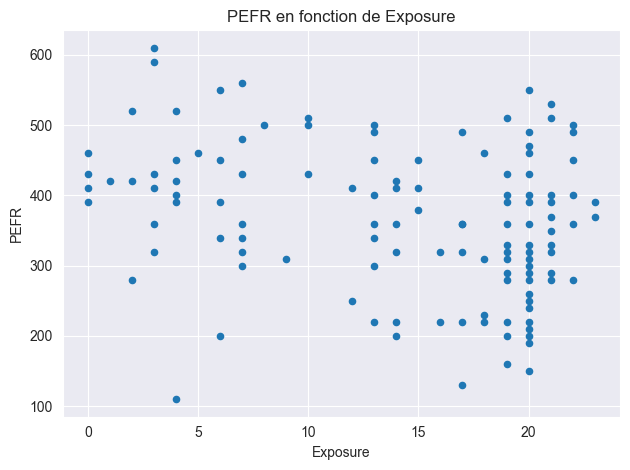

In [29]:
lung = pd.read_csv(LUNG_CSV)

lung.plot.scatter(x='Exposure', y='PEFR', style='o')
plt.title('PEFR en fonction de Exposure')
plt.tight_layout()
plt.show()

In [30]:
# Fit a linear regression model

predictors = ['Exposure'] # deux [[ pour obtenir un dataframe et non série
outcome = 'PEFR' # une seule [ pour obtenir une série

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'L intercept vaut {model.intercept_:.3f}'
      f' et le coeff vaut {model.coef_[0]:3f}')

L intercept vaut 424.583 et le coeff vaut -4.184576


On voit que plus le temps d'exposition augmente, plus le PEFR baisse. Cela semble cohérent. De plus, l'intercept vaut environ 425, ce qui signifie que selon ce modèle, une personne n'ayant jamais été exposé aux poussières possède un PEFR de 425.

## Valeurs ajustées et résidus

122


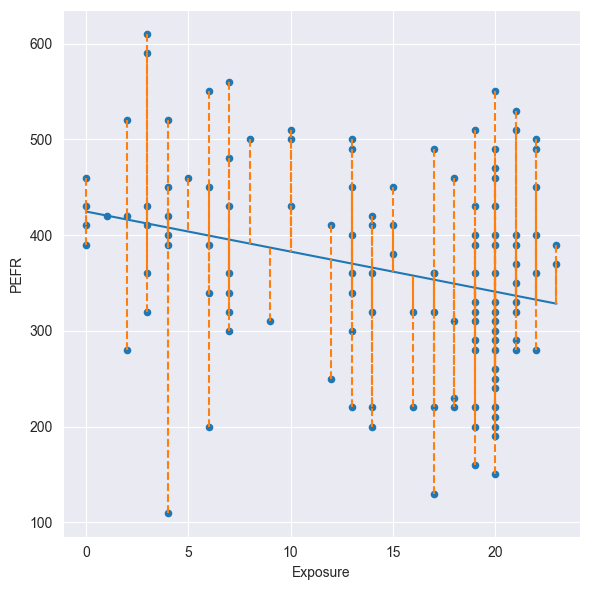

In [31]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

print(residuals.shape[0])

ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(6, 6))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

On voit ici en pointillé les érreurs du modèles qui ajoutées forment le résidu global.

## Méthodes des moindres carrés 

### Principe
La **régression des moindres carrés** est une méthode qui ajuste les données en minimisant la somme des carrés des résidus, aussi connue sous le nom de **RSS** (Residual Sum of Squares).

$$
RSS = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$

- $y_i$ représente la valeur observée pour l'observation $i$.
- $\hat{y}_i$ est la valeur prédite par le modèle pour l'observation $i$.
- $n$ est le nombre total d'observations dans le jeu de données.

Les paramètres du modèle, comme l'intercept $b_0$ et le coefficient $b_1$, sont calculés de manière à minimiser le RSS. Cette technique est appelée **régression des moindres carrés ordinaires** (OLS - Ordinary Least Squares).

### Avantages et Inconvénients
- **Avantage** : La régression des moindres carrés est rapide et facile à implémenter avec des logiciels statistiques standards.
- **Inconvénient** : Cette méthode est sensible aux **outliers** (valeurs extrêmes), surtout dans les ensembles de données de petite ou moyenne taille, car elle minimise les carrés des erreurs.

## Prédiction vs Explication en Régression

La régression peut être utilisée pour deux objectifs principaux : **expliquer** les relations entre variables ou **prédire** des résultats futurs.

### Explication
L'objectif est de comprendre la relation entre une ou plusieurs variables explicatives (X) et une variable de résultat (Y). Ici, l'intérêt principal réside dans la **pente** de l'équation de régression, qui indique comment un changement dans X affecte Y. On cherche à **analyser** et **interpréter** la relation globale entre les variables, plutôt que de prédire des cas spécifiques.
  
### Prédiction
Dans ce cas, la régression est utilisée pour **prédire** les résultats pour de nouvelles données. L'intérêt principal est dans les **valeurs ajustées** du modèle, qui permettent d'estimer Y pour de nouvelles valeurs de X. Ici, le but est de **générer des prédictions** précises pour de futures observations.


# Régression Linéaire Multiple

Lorsque plusieurs variables prédictives sont utilisées, l'équation de régression est simplement étendue pour les inclure. Au lieu d'une simple ligne, nous avons maintenant un **modèle linéaire** où la relation entre chaque coefficient et sa variable est linéaire.

$$
Y = b_0 + b_1X_1 + b_2X_2 + \cdots + b_nX_n
$$

- **\(Y\)** : la variable dépendante (ou cible) que l'on cherche à prédire.
- **\(b_0\)** : l'ordonnée à l'origine (intercept), c'est-à-dire la valeur prédite de \(Y\) lorsque toutes les variables prédictives \(X_1, X_2, ..., X_n\) valent 0.
- **\(b_1, b_2, ..., b_n\)** : les coefficients de régression qui mesurent l'effet de chaque variable prédictive \(X_1, X_2, ..., X_n\) sur \(Y\).
- **\(X_1, X_2, ..., X_n\)** : les variables indépendantes (ou prédicteurs) utilisées pour prédire \(Y\).

### Erreur quadratique moyenne (Root Mean Squared Error - RMSE)
La racine carrée de l'erreur quadratique moyenne de la régression. C'est la métrique la plus utilisée pour comparer les modèles de régression.

### Erreur standard des résidus (Residual Standard Error - RSE)
Identique à la RMSE, mais ajustée selon les degrés de liberté.

### R-carré (R-squared)
Proportion de la variance expliquée par le modèle, variant de 0 à 1.

### t-statistique
Le coefficient d'un prédicteur divisé par l'erreur standard de ce coefficient, donnant un indicateur pour comparer l'importance des variables dans le modèle.

### Régression pondérée (Weighted Regression)
Régression où les enregistrements ont des poids différents.


In [32]:
data = ['AdjSalePrice','SqFtTotLiving','SqFtLot','Bathrooms','Bedrooms','BldgGrade']


house = pd.read_csv(HOUSE_CSV, sep = '\t')
#print(house)
house[data].head(5)

,AdjSalePrice,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
1,300805.0,2400,9373,3.00,6,7
2,1076162.0,3764,20156,3.75,4,10
3,761805.0,2060,26036,1.75,4,8
4,442065.0,3200,8618,3.75,5,7
5,297065.0,1720,8620,1.75,4,7


In [33]:
# Le but est de prédire le prix de vente à partir des autres variables

predictors = ['SqFtTotLiving','SqFtLot','Bathrooms','Bedrooms','BldgGrade']
outcome = 'AdjSalePrice'

model_house = LinearRegression()
model_house.fit(house[predictors], house[outcome])

print(f'L intercept vaut {model_house.intercept_:.3f}')
for name, coefficient in zip(predictors, model_house.coef_):
    print(f"{name} : {coefficient}")

L intercept vaut -521871.368
SqFtTotLiving : 228.83060360240796
SqFtLot : -0.06046682065307607
Bathrooms : -19442.840398321056
Bedrooms : -47769.95518521438
BldgGrade : 106106.96307898083


# Évaluation du Modèle

La métrique de performance la plus importante du point de vue de la science des données est l'erreur quadratique moyenne (Root Mean Squared Error, ou **RMSE**). Le **RMSE** est la racine carrée de l'erreur quadratique moyenne dans les valeurs prédites :

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

où $y_i$ est la valeur observée, $\hat{y}_i$ est la valeur prédite, et $n$ est le nombre total de points de données.

Cela mesure l'exactitude globale du modèle et sert de base pour le comparer à d'autres modèles (y compris ceux obtenus par des techniques d'apprentissage automatique). 

Une métrique similaire au **RMSE** est l'erreur standard des résidus, ou **RSE**. Lorsque nous avons \(p\) prédicteurs, le **RSE** est donné par :

$$
RSE = \sqrt{\frac{1}{n - p - 1} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

La seule différence est que le dénominateur est ajusté par les degrés de liberté, au lieu du nombre total d'observations. En pratique, pour la régression linéaire, la différence entre **RMSE** et **RSE** est très faible, en particulier dans les applications de **big data** (diviser un très grand nombre par 5 ou 5+1=6 ne change pas réellement le résultat qui sera surement arrondie).


In [34]:
predicted = model_house.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome],predicted))
r2 = r2_score(house[outcome],predicted, sample_weight=None)

print(f"La RMSE vaut {RMSE:.0f}")
print(f"Le score r2 vaut {r2:.4f}")

La RMSE vaut 261220
Le score r2 vaut 0.5406


In [35]:
# Version avec StatsModel

model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:28:54   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694      0.000     221.189     236.472
SqFtLot          -0.0605      0.061     -0.988      0.323      -0.180       0.059
Bathrooms     -1.944e+04   3625.388     -5.363      0.000   -2.65e+04   -1.23e+04
Bedrooms      -4.777e+04   2489.732    -19.187      0.000   -5.27e+04   -4.29e+04
BldgGrade      1.061e+05   2396.445     44.277      0.000    1.01e+05    1.11e+05
const         -5.219e+05   1.57e+04    -33.342      0.000   -5.53e+05   -4.91e+05
==============================================================================
Omnibus:                    29676.557   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19390738.346
Skew:                           6.889   Prob(JB):                         0.00
Kurtosis:                     145.559   Cond. No.                     2.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Validation croisée

La validation croisée (**cross-validation**) est une méthode utilisée pour évaluer la performance d'un modèle tout en évitant le sur-apprentissage (**overfitting**). Elle permet de mesurer la capacité du modèle à généraliser sur de nouvelles données en le testant sur plusieurs sous-ensembles de données.

## Principe

La technique la plus courante est la **validation croisée k-fold**. Elle consiste à diviser l'ensemble des données en **k** sous-ensembles (ou "folds") de taille à peu près égale. Le modèle est ensuite entraîné **k** fois, à chaque fois en utilisant **k-1** sous-ensembles pour l'entraînement et le sous-ensemble restant pour tester le modèle.

Le processus est répété pour chaque sous-ensemble, et l'erreur moyenne des **k** modèles est utilisée comme estimation de la performance du modèle global.

### Étapes de la validation croisée k-fold :

1. Diviser les données en **k** sous-ensembles égaux.
2. Pour chaque itération :
   - Entraîner le modèle sur **k-1** sous-ensembles.
   - Tester le modèle sur le sous-ensemble restant.
3. Calculer la métrique d'évaluation (comme le RMSE ou la précision) pour chaque itération.
4. Obtenir la moyenne des métriques d'évaluation pour estimer la performance du modèle.

## Avantages

- **Réduction du surapprentissage** : En utilisant plusieurs jeux de test différents, la validation croisée aide à s'assurer que le modèle ne s'adapte pas trop aux particularités des données d'entraînement.
- **Utilisation efficace des données** : Chaque observation est utilisée à la fois pour l'entraînement et pour le test, maximisant l'usage des données disponibles.


In [36]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade',
              'PropertyType', 'NbrLivingUnits', 'SqFtFinBasement', 'YrBuilt',
              'YrRenovated', 'NewConstruction']

values = pd.get_dummies(house[predictors],drop_first=True, dtype=int)
values['NewConstruction'] = [1 if newc else 0 for newc in values['NewConstruction']]
print(values.dtypes)

model_house2 = sm.OLS(house[outcome], values.assign(const=1))
results = model_house2.fit()
print(results.summary())

SqFtTotLiving                   int64
SqFtLot                         int64
Bathrooms                     float64
Bedrooms                        int64
BldgGrade                       int64
NbrLivingUnits                  int64
SqFtFinBasement                 int64
YrBuilt                         int64
YrRenovated                     int64
NewConstruction                 int64
PropertyType_Single Family      int64
PropertyType_Townhouse          int64
dtype: object
                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:28:55   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:            

# Régression Pas à Pas (Stepwise Regression)

La **régression pas à pas** est une méthode pour sélectionner un sous-ensemble de variables explicatives à inclure dans un modèle de régression. Elle aide à identifier les variables les plus pertinentes tout en améliorant la performance du modèle.

## Types de Régression Pas à Pas

1. **Régression Pas à Pas Avant (Forward Selection)**
   - Commence avec un modèle vide.
   - Ajoute les variables une par une.
   - Sélectionne la variable qui améliore le plus le modèle.
   - Continue jusqu'à ce que plus aucune variable n'améliore significativement le modèle.

2. **Régression Pas à Pas Arrière (Backward Elimination)**
   - Commence avec un modèle complet.
   - Supprime les variables une par une.
   - Élimine la variable dont la suppression améliore le plus le modèle.
   - Continue jusqu'à ce qu'aucune autre variable ne puisse être éliminée sans détériorer le modèle.

3. **Régression Pas à Pas Bidirectionnelle (Stepwise Selection)**
   - Combine les approches avant et arrière.
   - Ajoute ou supprime des variables dynamiquement.

## Critères de Sélection

- **Critère d'Information d'Akaike (AIC) :** Évalue le modèle en tenant compte de la complexité et de l'ajustement. Un AIC plus bas est préférable.
- **Critère de Bayes (BIC) :** Similaire à l'AIC, mais avec une pénalisation plus sévère pour les modèles complexes.


In [37]:
y = house[outcome]

def train_model(var):
    if len(var) == 0:
        return None
    model = LinearRegression()
    model.fit(values[var], y)
    return model

def score_model(model, var):
    if len(var) == 0:
        return AIC_score(y, [y.mean()]*len(y), model, df = 1)
    return AIC_score(y, model.predict(values[var]), model)

best_model, best_var = stepwise_selection(values.columns, train_model, score_model, verbose=False)

print(f'L intercept vaut {best_model.intercept_:.2f}')
for name, coefficient in zip(best_var, best_model.coef_):
    print(f' {name} : {coefficient:.2f}')

L intercept vaut 6178645.02
 SqFtTotLiving : 199.28
 BldgGrade : 137159.56
 YrBuilt : -3565.42
 Bedrooms : -51947.38
 Bathrooms : 42396.16
 PropertyType_Townhouse : 84479.16
 SqFtFinBasement : 7.05
 PropertyType_Single Family : 22912.06


## AIC (Akaike Information Criterion)

L'**Akaike Information Criterion** (AIC) est une mesure utilisée pour comparer la qualité des modèles statistiques en prenant en compte à la fois la précision et la simplicité. Le principe sous-jacent de l'AIC est de favoriser les modèles qui offrent une bonne qualité d'ajustement tout en pénalisant les modèles trop complexes qui incluent des paramètres inutiles.

### Formule de l'AIC :

$
AIC = 2k - 2 \ln(L)
$

- **\( k \)** : le nombre de paramètres estimés dans le modèle.
- **\( L \)** : la valeur du maximum de la vraisemblance du modèle.

### Explication :

- **Complexité du modèle** : Le terme **2k** pénalise les modèles avec trop de paramètres, pour éviter le surajustement.
- **Qualité de l'ajustement** : Le terme $-2 \ln(L)$ mesure la qualité de l'ajustement du modèle par rapport aux données observées.

#### Utilisation de l'AIC :

- L'AIC est utilisé pour **comparer des modèles** entre eux. Le modèle avec la **plus petite valeur d'AIC** est généralement préféré car il offre un bon équilibre entre qualité d'ajustement et simplicité.
- Contrairement à d'autres critères, l'AIC ne donne pas une mesure absolue de la qualité du modèle mais sert à **comparer** différents modèles.


## Régression avec poids

In [38]:
house['year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
#print(house['year'])
house['weight'] = house['year'] - 2005
#print(house.weight)

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_weight = LinearRegression()
house_weight.fit(house[predictors], house[outcome], sample_weight= house.weight )

print(f'L intercept vaut {house_weight.intercept_:.3f}')
for name, coefficient in zip(predictors, house_weight.coef_):
    print(f"{name} : {coefficient}")

L intercept vaut -584189.329
SqFtTotLiving : 245.02408862720137
SqFtLot : -0.2924147480055357
Bathrooms : -26085.970108615045
Bedrooms : -53608.87643631369
BldgGrade : 115242.43472609227


# Prédictions en utilisant la régression

## Intervalles de Confiance et de Prédiction

### Introduction à l'incertitude
En statistique, il est crucial de comprendre et de mesurer la variabilité (incertitude). Les **intervalles de confiance** et les **intervalles de prédiction** permettent de quantifier cette incertitude dans les modèles de régression. Bien que les t-statistiques et les p-valeurs soient utiles, les intervalles de confiance fournissent une mesure plus intuitive de l'incertitude autour des coefficients de régression et des prédictions.

### Intervalles de Confiance pour les Coefficients de Régression
Les intervalles de confiance sont souvent présents dans les résultats de régression pour indiquer l’incertitude autour des coefficients. Une méthode courante pour calculer ces intervalles est la **méthode bootstrap**.

### Intervalles de Prédiction pour les Valeurs Prédites
Les intervalles de prédiction mesurent l'incertitude autour des valeurs prédictives individuelles. L'incertitude vient de deux sources :

1. **Incertitude des coefficients du modèle** (incertitude sur les variables prédictives et leurs coefficients).
2. **Erreur inhérente aux points de données individuels**, qui reflète la variabilité naturelle des observations, même si l'équation de régression est parfaitement connue.

### Différence entre Intervalle de Confiance et Intervalle de Prédiction
Un **intervalle de confiance** concerne l'incertitude autour d'une moyenne ou d'une statistique calculée à partir de plusieurs valeurs, tandis qu'un **intervalle de prédiction** concerne l'incertitude autour d'une valeur individuelle prédite. Par conséquent, un intervalle de prédiction est généralement plus large qu'un intervalle de confiance pour la même valeur.

### Idées Clés
- **Les intervalles de confiance** quantifient l'incertitude autour des coefficients de régression.
- **Les intervalles de prédiction** quantifient l'incertitude dans les prédictions individuelles.
- L'**extrapolation** au-delà des données disponibles peut mener à des erreurs.


In [39]:
house.PropertyType.head()

pd.get_dummies(house.PropertyType).head(5)
pd.get_dummies(house.PropertyType, drop_first=True)

# drop_first sert a eliminer la premiere variable pour eviter les problemes de multicolinéarité. 

,Single Family,Townhouse
1,False,False
2,True,False
3,True,False
4,True,False
5,True,False
...,...,...
27057,True,False
27058,True,False
27061,True,False
27062,True,False


In [40]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

values = pd.get_dummies(house[predictors], drop_first=True)

house_factor = LinearRegression()
house_factor.fit(values, house[outcome])

print(f'Intercept: {house_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(values.columns, house_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503822
 SqFtLot: -0.0703679813681255
 Bathrooms: -15979.013473415183
 Bedrooms: -50889.73218483028
 BldgGrade: 109416.3051614618
 PropertyType_Single Family: -84678.21629549256
 PropertyType_Townhouse: -115121.97921609186


## Outliers


In [41]:
zip_98105 = house.loc[house['ZipCode'] == 98105]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

outlier = sm.OLS(zip_98105[outcome], zip_98105[predictors].assign(const = 1))

res = outlier.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          1.69e-103
Time:                        22:28:57   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587      0.000     161.574     257.631
SqFtLot          38.9333      5.330      7.305      0.000      28.445      49.421
Bathrooms      2282.2641      2e+04      0.114      0.909    -3.7e+04    4.16e+04
Bedrooms      -2.632e+04   1.29e+04     -2.043      0.042   -5.17e+04    -973.867
BldgGrade        1.3e+05   1.52e+04      8.533      0.000       1e+05     1.6e+05
const         -7.725e+05   9.83e+04     -7.861      0.000   -9.66e+05   -5.79e+05
==============================================================================
Omnibus:                       82.127   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              586.561
Skew:                           0.859   Prob(JB):                    4.26e-128
Kurtosis:                       9.483   Cond. No.                     5.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
influence = OLSInfluence(res)
sresiduals = influence.resid_studentized_internal
sresiduals.idxmin(), sresiduals.min()

(24333, -4.326731804078561)

In [43]:
outlier = zip_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


In [44]:
print(res.resid.loc[sresiduals.idxmin()])

-757753.6192115824


## Influence des variables

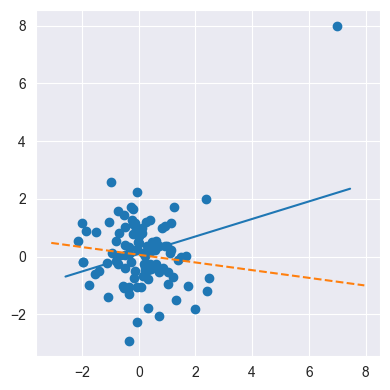

In [45]:
from scipy.stats import linregress

np.random.seed(10)
x = np.random.normal(size=100)
y = -x / 5 + np.random.normal(size=100)
x[0] = 7
y[0] = 8

def abline(slope, intercept, ax):
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
plt.tight_layout()
plt.show()

## Distance de Cook

La **Distance de Cook** est une mesure de l'influence d'une observation individuelle dans un modèle de régression. Elle combine deux éléments :

1. **Leverage** : La position de l'observation par rapport aux autres points de données.
2. **Taille du résidu** : L'écart entre la valeur observée et la valeur prédite par le modèle.

### Utilisation
La Distance de Cook est utilisé pour identifier les observations qui ont une influence excessive sur les résultats de la régression. Une règle courante est de considérer qu'une observation a une influence significative si sa distance de Cook dépasse la valeur seuil de :

$$ \frac{4}{n-P-1} $$

où **n** est le nombre total d'observations dans l'échantillon.

### Importance
- Si une observation a une Cook's distance élevée, cela signifie qu'elle pourrait affecter fortement l'estimation des coefficients du modèle.
- Elle aide à détecter des points aberrants ou influents qui peuvent biaiser les résultats de la régression.


Text(0, 0.5, 'studentized residuals')

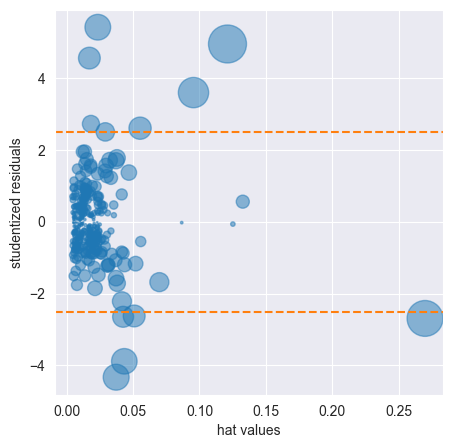

In [46]:
influence = OLSInfluence(res)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)
ax.set_xlabel('hat values')
ax.set_ylabel('résidus normalisés')

In [47]:
data_without_outliers = [dist < .08 for dist in influence.cooks_distance[0]]
house_data_without_outliers = zip_98105.loc[data_without_outliers]

ols_infl = sm.OLS(house_data_without_outliers[outcome], house_data_without_outliers[predictors].assign(const=1))
res_data = ols_infl.fit()

pd.DataFrame({
    'avec outlier': res.params,
    'sans outlier': res_data.params,
})

,avec outlier,sans outlier
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


## Hétéroscédasticité, Non-Normalité et Erreurs Corrélées


Dans l'analyse des résidus d'un modèle de régression, plusieurs éléments doivent être pris en compte pour assurer la validité des inférences statistiques et la qualité des prédictions.

### Hétéroscédasticité
L’hétéroscédasticité se produit lorsque la variance des résidus change en fonction des valeurs prédites. Cela signifie que les erreurs de prédiction sont plus grandes pour certaines parties de la plage des valeurs prédites. Par exemple, dans un modèle de prix de maisons, l’hétéroscédasticité pourrait indiquer que le modèle n'explique pas bien les variations des prix des maisons de très faible ou de très haute valeur. On peut visualiser cela en traçant les résidus absolus contre les valeurs prédites. Une courbe lissée avec la méthode **loess** peut montrer comment la variance change.

### Non-Normalité
La non-normalité des résidus indique que le modèle ne capture pas complètement les relations entre les variables. Les tests statistiques comme les p-values ou les intervalles de confiance reposent sur l’hypothèse que les résidus sont normalement distribués. Si ce n'est pas le cas, les conclusions basées sur ces tests peuvent être biaisées.

### Corrélation des Erreurs
Les erreurs dans un modèle doivent être indépendantes. Si elles sont corrélées (autocorrélation), par exemple dans des données temporelles ou spatiales, cela peut affecter les prédictions. La statistique de **Durbin-Watson** permet de détecter cette corrélation. Lorsque des erreurs corrélées sont détectées, des ajustements au modèle sont nécessaires pour tenir compte de cette dépendance, en particulier pour les prévisions à court terme.

Text(0, 0.5, 'abs(residus)')

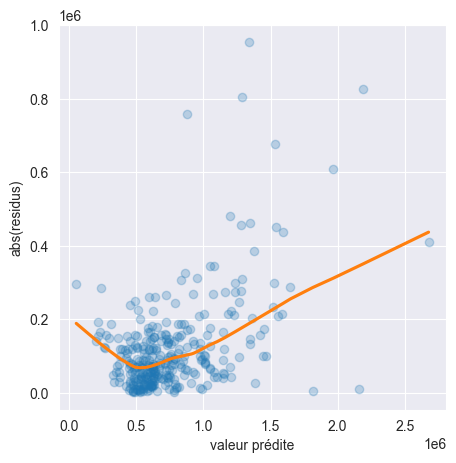

In [48]:
fig, ax = plt.subplots(figsize = (5,5))
sns.regplot(x=res.fittedvalues, y=np.abs(res.resid),
            scatter_kws={'alpha' : 0.25}, line_kws={'color':'C1'},
            lowess=True, ax=ax)

ax.set_xlabel('valeur prédite')
ax.set_ylabel('abs(residus)')

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

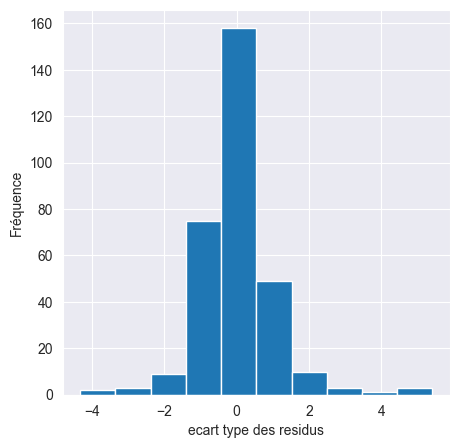

In [49]:
fig, ax = plt.subplots(figsize=(5,5))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('ecart type des residus')
ax.set_ylabel('Fréquence')
plt.tight_layout

## Graphes de Résidus Partiels et Non-linéarité



### Qu'est-ce qu'un résidu partiel ?

Un résidu partiel combine le résidu du modèle de régression complet avec la valeur prédite d'un seul prédicteur. Il montre la contribution de ce prédicteur au résultat global. Mathématiquement, il peut être exprimé comme suit :

$$ \text{Résidu Partiel} = \text{Résidu} + \beta_j X_j $$

Où :
- $ \beta_j $ est le coefficient du prédicteur $ X_j $.

Cela nous permet d'examiner comment un prédicteur explique le résultat, au-delà des effets des autres variables.

### Interpréter les graphes de résidus partiels

Dans un graphe de résidus partiels, le prédicteur est tracé sur l'axe des x, et les résidus partiels sur l'axe des y. Le graphique révèle la contribution du prédicteur au résultat, mettant en évidence une éventuelle **non-linéarité** dans la relation.

Par exemple, dans le cas de **SqFtTotLiving** (superficie totale habitable), le graphique de résidus partiels pourrait montrer que les petites maisons connaissent une augmentation de prix par pied carré plus importante par rapport aux grandes maisons. Cela indique que la relation entre la superficie et le prix de vente est non linéaire.

### Pourquoi la non-linéarité est-elle importante ?

Si une relation est non linéaire, un terme de régression linéaire simple peut ne pas la capturer correctement. Dans le cas des données sur l'immobilier, ajouter 500 pieds carrés à une petite maison a un impact plus grand que d'ajouter 500 pieds carrés à une grande maison. Un graphe de résidus partiels peut mettre en évidence cette non-linéarité et suggérer la nécessité d'un modèle plus complexe, tel que l'incorporation d'un **terme non linéaire** (par exemple, un polynôme ou un spline).

In [50]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

NameError: name 'result_98105' is not defined

<Figure size 800x1200 with 0 Axes>

# Régression polynomiale et Spline

## Qu'est-ce que la Régression Polynômiale ?

La régression polynomiale est une méthode de modélisation statistique qui permet d'établir une relation entre une variable dépendante et une ou plusieurs variables indépendantes en utilisant un polynôme. Contrairement à la régression linéaire, qui suppose une relation linéaire, la régression polynomiale peut capturer des relations non linéaires.

## Forme Générale

La forme générale d'une régression polynomiale de degré \( n \) est :

$$ Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \ldots + \beta_n X^n + \epsilon $$

où :
- \( Y \) est la variable dépendante.
- \( X \) est la variable indépendante.
- \( \beta_0, \beta_1, \ldots, \beta_n \) sont les coefficients du modèle.
- \( \epsilon \) est l'erreur aléatoire.

## Exemples d'Applications

1. **Modélisation de la Croissance** : Utilisée pour modéliser la croissance des plantes en fonction des nutriments.
2. **Analyse Économique** : Peut être appliquée pour évaluer l'impact des dépenses marketing sur les ventes, où la relation peut ne pas être linéaire.
3. **Prédictions Scientifiques** : Utilisée dans divers domaines scientifiques pour ajuster des courbes à des données expérimentales.

## Avantages

- **Flexibilité** : Peut s'adapter à une grande variété de formes de données.
- **Capturer des Relations Complexes** : Permet de mieux modéliser des phénomènes non linéaires.

## Inconvénients

- **Risque de Surajustement** : Un modèle trop complexe peut s'ajuster aux bruits des données plutôt qu'à la tendance réelle.
- **Choix du Degré** : Déterminer le degré du polynôme approprié peut être difficile.





In [106]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + ' +
                '+ I(SqFtTotLiving**2) + ' +
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
result_poly.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          9.95e-106
Time:                        14:30:41   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -6.159e+05   1.03e+05     -5.953      0.000   -8.19e+05   -4.12e+05
SqFtTotLiving             7.4521     55.418      0.134      0.893    -101.597     116.501
I(SqFtTotLiving ** 2)     0.0388      0.010      4.040      0.000       0.020       0.058
SqFtLot                  32.5594      5.436      5.990      0.000      21.863      43.256
Bathrooms             -1435.1231   1.95e+04     -0.074      0.941   -3.99e+04     3.7e+04
Bedrooms              -9191.9441   1.33e+04     -0.693      0.489   -3.53e+04    1.69e+04
BldgGrade              1.357e+05   1.49e+04      9.087      0.000    1.06e+05    1.65e+05
==============================================================================
Omnibus:                       75.161   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.978
Skew:                           0.699   Prob(JB):                    2.92e-139
Kurtosis:                       9.853   Cond. No.                     7.37e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Spline

In [111]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' +
          'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
result_spline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          7.10e-104
Time:                        14:37:55   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -4.142e+05   1.43e+05     -2.899      0.004   -6.95e+05   -1.33e+05
bs(SqFtTotLiving, df=6, degree=3)[0] -1.995e+05   1.86e+05     -1.076      0.283   -5.65e+05    1.66e+05
bs(SqFtTotLiving, df=6, degree=3)[1] -1.206e+05   1.23e+05     -0.983      0.326   -3.62e+05    1.21e+05
bs(SqFtTotLiving, df=6, degree=3)[2] -7.164e+04   1.36e+05     -0.525      0.600    -3.4e+05    1.97e+05
bs(SqFtTotLiving, df=6, degree=3)[3]  1.957e+05   1.62e+05      1.212      0.227   -1.22e+05    5.14e+05
bs(SqFtTotLiving, df=6, degree=3)[4]  8.452e+05   2.18e+05      3.878      0.000    4.16e+05    1.27e+06
bs(SqFtTotLiving, df=6, degree=3)[5]  6.955e+05   2.14e+05      3.255      0.001    2.75e+05    1.12e+06
SqFtLot                                 33.3258      5.454      6.110      0.000      22.592      44.059
Bathrooms                            -4778.2080   1.94e+04     -0.246      0.806    -4.3e+04    3.34e+04
Bedrooms                             -5778.7045   1.32e+04     -0.437      0.663   -3.18e+04    2.03e+04
BldgGrade                             1.345e+05   1.52e+04      8.842      0.000    1.05e+05    1.64e+05
==============================================================================
Omnibus:                       58.816   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              622.021
Skew:                           0.330   Prob(JB):                    8.51e-136
Kurtosis:                       9.874   Cond. No.                     1.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/var/folders/fr/nprtm9vx3zs9rx_j2kxtz_b80000gn/T/ipykernel_806/250720817.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'ypartial': feature_prediction - model.params[0],


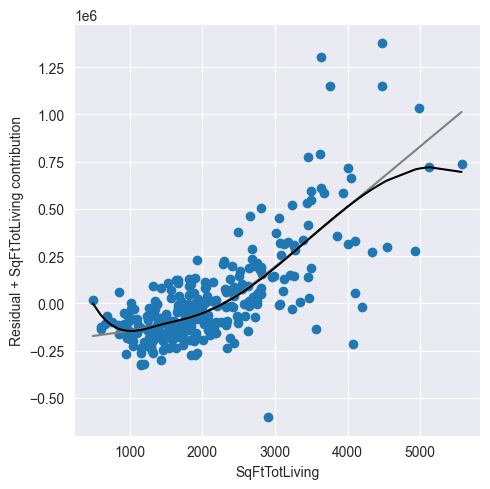

In [112]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()